# Практическая работа 1

## Импортируем библиотеки

In [1]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
from torch import nn
from torch import optim

import math

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool

## Функции
Берем все те же функции из статьи 

In [2]:
def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])

In [3]:
def jacobian(outputs, inputs, create_graph=False):
    '''
    Compute the Jacobian of `outputs` with respect to `inputs`
    jacobian(x, x)
    jacobian(x * y, [x, y])
    jacobian([x * y, x.sqrt()], [x, y])
    '''
    if torch.is_tensor(outputs):
        outputs = [outputs]
    else:
        outputs = list(outputs)

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    jac = []
    for output in outputs:
        output_flat = output.view(-1)
        output_grad = torch.zeros_like(output_flat)
        for i in range(len(output_flat)):
            output_grad[i] = 1
            jac += [gradient(output_flat, inputs, output_grad, True, create_graph)]
            output_grad[i] = 0
    return torch.stack(jac)

In [4]:
def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    Compute the Hessian of `output` with respect to `inputs`
    hessian((x * y).sum(), [x, y])
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)

    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad

    return out

## Устройство

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Модель 

В качестве модели рассматривалась полносвязная нейросеть c одним скрытым слоем.

In [6]:
class Neural_model(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=3, output_dim=1, device='cpu'):
        """
        """
        super(Neural_model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.device = device

        self.network = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
        )
        
        self.output = nn.Linear(self.hidden_dim, self.output_dim)
        
        list_of_params = []
        for param in self.parameters():
            list_of_params.append(param.data.view(-1))
        self.D = len(torch.cat(list_of_params).view(-1))

        list_of_hyperparams = []
        for param in self.parameters():
            list_of_hyperparams.append(torch.ones_like(param.data, requires_grad=True))
        
        self.list_of_hyperparams = list_of_hyperparams
        
        self.to(device)

        
    def forward(self, input):
        x = input
        x = self.network(x)
        return self.output(x)
    
    def log_prior_w(self, w, h):

        w = w.view(-1)
        h = h.view(-1)
        return -0.5*torch.dot(w*(h**2), w)
      
    def log_prior_all(self):
        T = 0
        i_T = 0
        for param, hyperparam in zip(self.parameters(), self.list_of_hyperparams):
            T += self.log_prior_w(param, hyperparam)
        return T
     
    def loglikelihood(self, batch_x, batch_y):

        return -0.5*torch.mean((self.forward(batch_x) - batch_y)**2)
    
    def margin_log_likelihood(self, batch_x, batch_y):

        T = self.log_prior_all() + self.loglikelihood(batch_x, batch_y)
        return T
    
    def loss(self, batch_x, batch_y):
        prediction = self.forward(batch_x)
        return nn.MSELoss()(prediction, batch_y)
    
#     Добавим необходимые функции: инициализации, обнуления и задания гиперпараметров и их градиентов
    
    def random_hyperparam(self):
        for h in self.list_of_hyperparams:
            h.data = torch.rand_like(h.data)

    def zero_grad_hyperparam(self):
        for h in self.list_of_hyperparams:
            h.grad.zero_()

    def set_grad_hyperparam(self, grad):
        bias = 0
        for param in self.list_of_hyperparams:
            param_size = torch.tensor(param.size()).prod()
            param.grad = grad[bias:bias+param_size].view_as(param)
            bias+=param_size
            
    def set_data_hyperparam(self, data):
        bias = 0
        for h in self.list_of_hyperparams:
            h_size = torch.tensor(h.size()).prod()
            h.data = data[bias:bias+h_size].view_as(h)
            if h.grad is not None:
                h.grad.zero_()
            bias+=h_size

## Эксперимент

Реализуем совсем простую выборку

In [7]:
def get_dataset(w, m,n,eps):
    
    X = np.random.randn(m, n)
    Y = (X@w + eps*np.random.randn(m)).reshape([-1, 1])
    return X,Y

In [8]:
m = 150
n = 20
eps = 0.001

w = np.random.randn(n)

X_train, Y_train = get_dataset(w, m,n,eps)
X_test, Y_test = get_dataset(w, m,n,eps)
X_valid, Y_valid = get_dataset(w, m,n,eps)

In [9]:
train_data = TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(Y_train).to(device))
X_tr, Y_tr = train_data[:]
valid_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))
X_valid, Y_valid = valid_data[:]
test_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))
X_ts, Y_ts = test_data[:]

# Random Search

In [10]:
def hyperarray(model):
    list_of_hyperparams = []
    for h in model.list_of_hyperparams:
        list_of_hyperparams.append(h.data.cpu().numpy().reshape(-1))

    return np.hstack(list_of_hyperparams)
# Сохраняем параметры в numpy массиве

def get_loss_param_hyper(model, hyper):

    model.__init__(model.input_dim, model.hidden_dim, model.output_dim, model.device)
    model.set_data_hyperparam(hyper)
    
    optimazer = optim.Adam(model.parameters(), lr=0.01)

    steps = []

    for epoch in range(200):
        generator = DataLoader(train_data, batch_size=64, shuffle=True)
        for batch_x, batch_y in generator:
            model.zero_grad()
            loss = -model.margin_log_likelihood(batch_x, batch_y)
            loss.backward()
            optimazer.step()
            
    return hyperarray(model), model.loss(X_valid, Y_valid).item()
# Считаем ошибку на валидационной выборке
    

In [11]:
def random_search(number_of_search = 10, model = None):
    hyperparams = []
    losses = []

    for _ in tqdm(range(number_of_search)):
        hyperparam = torch.rand(model.D)
        hyperparam, loss_of_f = get_loss_param_hyper(model, hyperparam)

        hyperparams.append(hyperparam)
        losses.append(loss_of_f)

    return np.array(hyperparams), np.array(losses)


In [12]:
model = Neural_model(input_dim=n, output_dim=1, hidden_dim=1)

In [13]:
%%time
hyperparams_rand, losses_rand = random_search(200, model)


CPU times: user 3min 5s, sys: 5.75 s, total: 3min 11s
Wall time: 3min 15s


In [14]:
model.loss(X_tr, Y_tr)

tensor(2.8413, grad_fn=<MseLossBackward>)

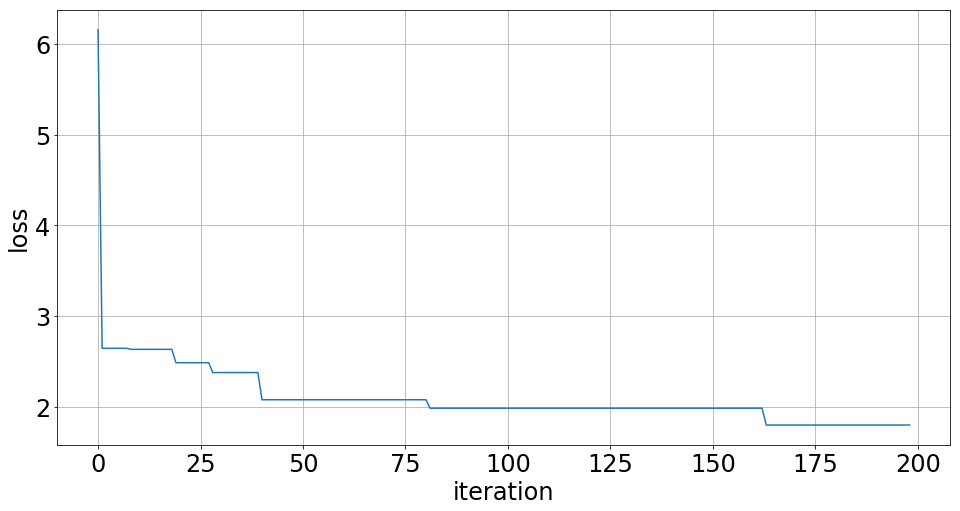

In [37]:
k = len(losses_rand)
_ = plt.plot([np.min(losses_rand[:i]) for i in range(1, k)])
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 24
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid()
plt.show()

In [17]:
poss = np.argmin(losses_rand)
optimal_hyperparam_rand = hyperparams_rand[poss]
optimal_loss_rand = losses_rand[poss]
print(optimal_hyperparam_rand)
print('\n')
print(optimal_loss_rand)

[0.45583606 0.6268117  0.2495963  0.5435631  0.61643946 0.57098174
 0.92471147 0.5416199  0.9154121  0.5861751  0.88748235 0.7966057
 0.8623083  0.81819975 0.99346834 0.8772899  0.4746846  0.2629453
 0.9281426  0.6055253  0.17288554 0.01675969 0.12517273]


1.7995758056640625


Скорость выполнения как ни странно довольно быстрая, а также алгоритм быстро сходится на ранних итерациях.

Поскольку берется аргумент минимума, то функция получается ступенчатой.

## HOAG

In [18]:
model = Neural_model(input_dim=n, output_dim=1, hidden_dim=1)
model.random_hyperparam()

optimazer_theta = optim.Adam(model.parameters(), lr=0.01)
optimazer_h = optim.SGD(model.list_of_hyperparams, lr=0.01)

List_of_h = []
List_of_loss = []

In [19]:
%%time

for epoch in tqdm(range(200)):
    for ep in range(200):
        generator = DataLoader(train_data, batch_size=64, shuffle=True)
        for batch_x, batch_y in generator:
            model.zero_grad()
            loss = -model.margin_log_likelihood(batch_x, batch_y)
            loss.backward()
            optimazer_theta.step()
    
    model.zero_grad()
    model.zero_grad_hyperparam()
    hess = hessian(-model.margin_log_likelihood(X_valid, Y_valid), model.parameters())
    
    model.zero_grad_hyperparam()
    model.zero_grad()
    grad = gradient(model.loss(X_valid, Y_valid), model.parameters())

    lambd = torch.inverse(hess)@grad

    model.zero_grad_hyperparam()
    model.zero_grad()
    grad = gradient(-model.margin_log_likelihood(X_valid, Y_valid), model.parameters(), create_graph=True)

    mat = torch.cat([gradient(gr, model.list_of_hyperparams, retain_graph=True).view([-1, 1]) for gr in grad], dim = 1)

    full_grad = -mat.transpose(0,1)@lambd

    model.zero_grad()
    model.zero_grad_hyperparam()
    model.set_grad_hyperparam(full_grad)

    optimazer_h.step()
    List_of_h.append(hyperarray(model))
    List_of_loss.append(model.loss(X_valid, Y_valid).item())

    

List_of_h = np.array(List_of_h)
List_of_loss = np.array(List_of_loss)


CPU times: user 3min 6s, sys: 5.78 s, total: 3min 12s
Wall time: 3min 15s


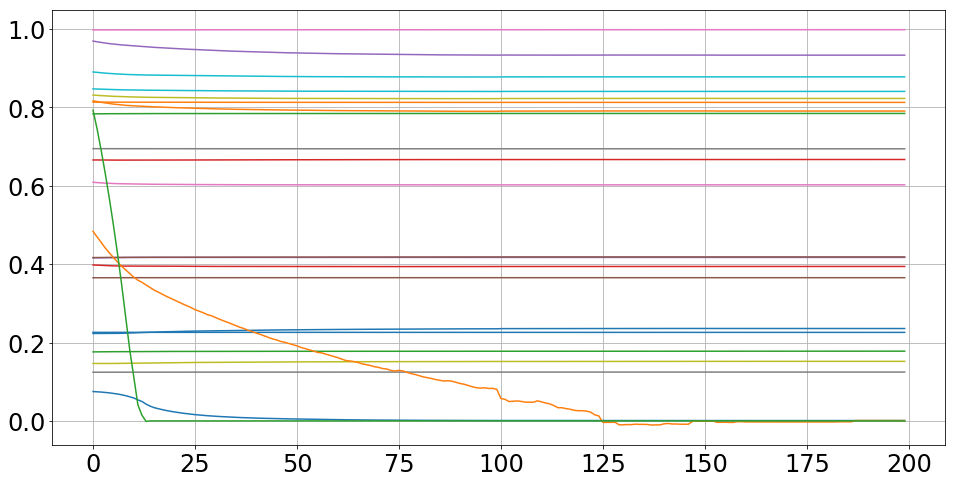

In [20]:
_ = plt.plot(List_of_h)
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 24
plt.grid()
plt.show()

Замечаем, что лишь три гиперпараметра значительно изменили свои значения 

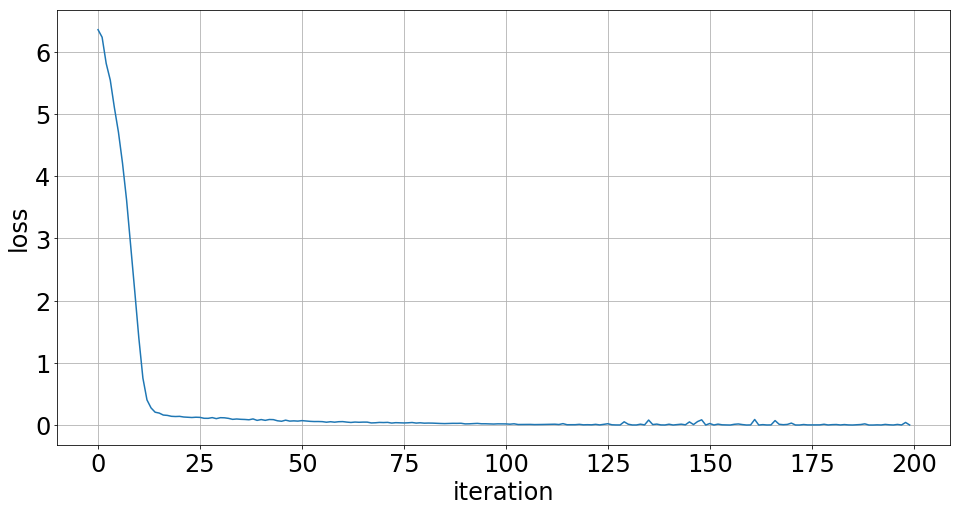

In [36]:
_ = plt.plot(List_of_loss)
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 24
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid()
plt.show()

Не смотря на то, что время было затрачено в полтора раз дольше, точность, получаемая этим алгоритмом намного лучше. Также алгоритм быстро сходится в начале, поэтому имеет смысл делать технику рестартов.

# Гаусовский процесс

In [23]:

from pyGPGO.covfunc import squaredExponential
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO
from pyGPGO.covfunc import matern32

In [24]:
model = Neural_model(input_dim=n, output_dim=1, hidden_dim=1)
D = model.D

param_dict = dict()

for i in range(D):
    param_dict['h'+str(i)] = ('cont', [0, 1])

In [25]:
param_dict

{'h0': ('cont', [0, 1]),
 'h1': ('cont', [0, 1]),
 'h10': ('cont', [0, 1]),
 'h11': ('cont', [0, 1]),
 'h12': ('cont', [0, 1]),
 'h13': ('cont', [0, 1]),
 'h14': ('cont', [0, 1]),
 'h15': ('cont', [0, 1]),
 'h16': ('cont', [0, 1]),
 'h17': ('cont', [0, 1]),
 'h18': ('cont', [0, 1]),
 'h19': ('cont', [0, 1]),
 'h2': ('cont', [0, 1]),
 'h20': ('cont', [0, 1]),
 'h21': ('cont', [0, 1]),
 'h22': ('cont', [0, 1]),
 'h3': ('cont', [0, 1]),
 'h4': ('cont', [0, 1]),
 'h5': ('cont', [0, 1]),
 'h6': ('cont', [0, 1]),
 'h7': ('cont', [0, 1]),
 'h8': ('cont', [0, 1]),
 'h9': ('cont', [0, 1])}

In [26]:
%%time

def f(**argv):
    x = []
    for par in argv:
        x.append(argv[par])
    if not torch.is_tensor(x):
        x = torch.tensor(x)
# так как максимизирует библиотека возьмем ошибку со знаком минус
    return -get_loss_param_hyper(model, x)[1]


sexp = matern32()
gp = GaussianProcess(sexp, optimize=True, usegrads=True)
acq = Acquisition(mode='ExpectedImprovement')

np.random.seed(23)
gpgo = GPGO(gp, acq, f, param_dict)
gpgo.run(max_iter=50)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.51729788 0.9469626  0.76545976 0.28239584 0.22104536 0.68622209
 0.1671392  0.39244247 0.61805235 0.41193009 0.00246488 0.88403218
 0.88494754 0.30040969 0.58958187 0.97842692 0.84509382 0.06507544
 0.29474446 0.28793444 0.82246634 0.62618304 0.11047771]. 	  -3.3168962001800537 	 -2.868901252746582
init   	 [5.28811169e-04 9.42166233e-01 1.41500758e-01 4.21596526e-01
 3.46489440e-01 8.69785084e-01 4.28601812e-01 8.28751484e-01
 7.17851838e-01 1.19226694e-01 5.96384173e-01 1.29756298e-01
 7.75340917e-02 8.31205256e-01 4.64385615e-01 1.62012479e-01
 5.47975292e-01 5.88485822e-01 7.73613169e-01 6.55845458e-01
 5.57706759e-01 1.78247267e-01 2.40583531e-01]. 	  -2.868901252746582 	 -2.868901252746582
init   	 [0.50605463 0.3967457  0.48305519 0.95573984 0.90160219 0.50575932
 0.82070149 0.82771593 0.23183335 0.07905549 0.46576293 0.87897581
 0.14750306 0.23125131 0.91794581 0.12906353 0.91640772 0.23479755
 0.61598677 0.9

46     	 [0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]. 	  -6.63370943069458 	 -1.5398677587509155
47     	 [1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]. 	  -2.4780502319335938 	 -1.5398677587509155
48     	 [0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.]. 	  -1.9510103464126587 	 -1.5398677587509155
49     	 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0.]. 	  -2.431997776031494 	 -1.5398677587509155
50     	 [0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.]. 	  -2.1694369316101074 	 -1.5398677587509155
CPU times: user 19min 36s, sys: 32.9 s, total: 20min 9s
Wall time: 19min 43s


In [29]:
List_of_loss_gaus = -1*np.array(gpgo.history)

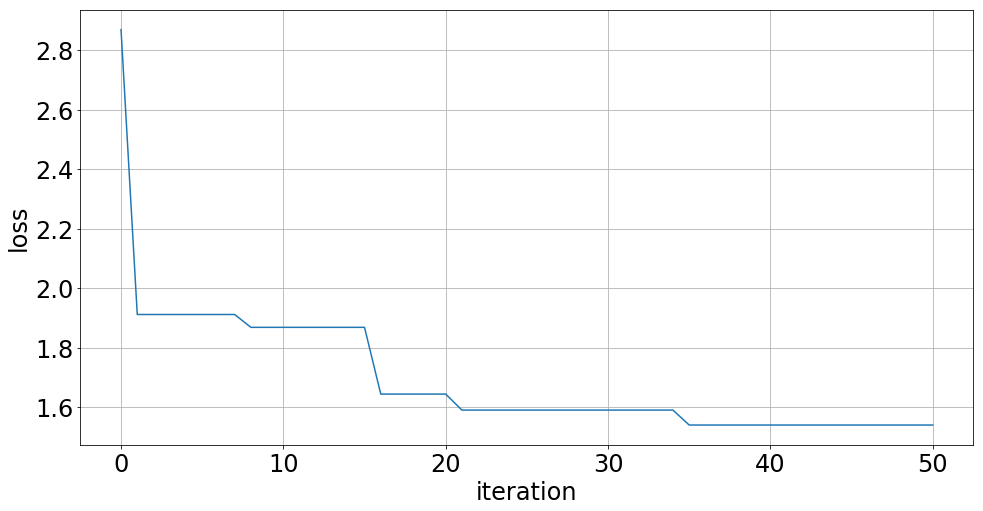

In [35]:
_ = plt.plot(List_of_loss_gaus)
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 24
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid()
plt.show()

In [38]:
best_h_gaus, best_loss_gaus = gpgo.getResult()[0], -gpgo.getResult()[1]
List_of_h = []
for key in best_h_gaus:
    List_of_h.append(best_h_gaus[key])
    
best_h_gaus = np.array(List_of_h)
print(best_h_gaus)
print('\n')
print(best_loss_gaus)

[0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.]


1.5398677587509155


## Анализ результатов

Выведем все графики вместе:

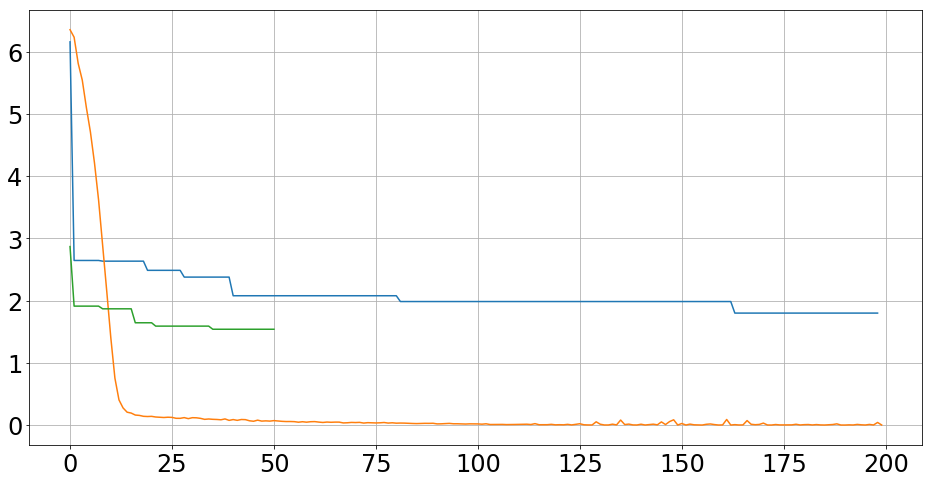

In [34]:
plt.plot([np.min(losses_rand[:i]) for i in range(1, k)])
plt.plot(List_of_loss)
plt.plot(List_of_loss_gaus)
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 24
plt.grid()
plt.show()

Метод с гауссовыми процессами самый медленный и при этом качество имеет не сильно лучше, чем случайный поиск.

Случайный поиск самый быстрый, однако его качество желает быть лучшим.

Самый успешный метод это HOAG, он не сильно медленнее, чем случайный поиск, но при этом его качество намного лучше остальных